In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 

from scipy import sparse, stats
from scipy.special import gammaln
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni
from itertools import combinations, permutations


import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240409-14:03:13,354 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 15 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/density-{args.denst}'
FC_path = f'{ROI_RESULTS_path}/corr_mats'
SBM_path = f'{ROI_RESULTS_path}/sbms'

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

<Axes: >

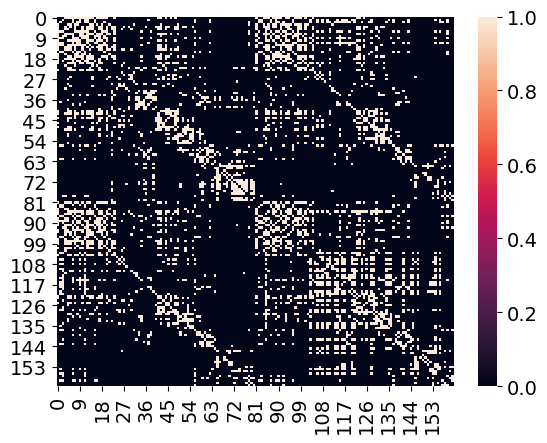

In [5]:
files = glob.glob(f'{FC_path}/*', recursive=True)
file = files[19]
g = gt.load_graph(file)

sns.heatmap(gt.adjacency(g).todense())

In [6]:
def mcmc_eq(args, g, state):
    bs = [] # partitions
    Bs = np.zeros(g.num_vertices() + 1) # number of partitions
    dls = [] # description length history
    def collect_partitions(s):
        bs.append(s.b.a.copy())
        B = s.get_nonempty_B()
        Bs[B] += 1
        dls.append(s.entropy())
        
    gt.mcmc_equilibrate(
        state, 
        wait=args.wait, 
        # force_niter=args.force_niter,
        mcmc_args=dict(niter=args.niter), 
        callback=collect_partitions,
    )
    return state, bs, Bs, dls

def nested_mcmc_eq(args, g, state):
    bs = []
    Bs = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
    dls = []
    def collect_partitions(s):
        bs.append(s.get_bs())
        Bs_ = []
        for l, sl in enumerate(s.get_levels()):
            B = sl.get_nonempty_B()
            Bs[l][B] += 1
        dls.append(s.entropy())
        
    gt.mcmc_equilibrate(
        state, 
        wait=args.wait, 
        # force_niter=args.force_niter, 
        mcmc_args=dict(niter=args.niter),
        callback=collect_partitions,
    )
    return state, bs, Bs, dls

In [7]:
def rescale(X):
    X /= np.expand_dims(np.sum(X, axis=-1), axis=-1)
    X = np.nan_to_num(X)
    X = np.round(X, decimals=3)
    return X

def get_marginals(args, g, state, mode):
    # vertex marginals of the graph in the state, 
    # if overlapping state, it is graph of half-edges
    sg = state.g
    B = mode.get_B()
    print(f'{B} blocks')
    v_marginals = np.zeros((sg.num_vertices(), B))
    for idx, prob in zip(sg.iter_vertices(), mode.get_marginal(sg)):
        prob = list(prob)
        prob = prob if len(prob) < B else prob[:B]
        prob = prob + [0]*(B - len(prob))
        v_marginals[idx] = np.array(prob)

    v_marginals = rescale(v_marginals)
    
    if args.sbm in ['o']:
        # average of probs. of half-edges incident on a vertex
        marginals = np.zeros((g.num_vertices(), v_marginals.shape[-1]))
        for v, hes in zip(g.iter_vertices(), state.half_edges):
            marginals[v] = np.mean(v_marginals[hes], axis=0)
    else:
        marginals = v_marginals.copy()
    return marginals

def get_mode_marginals(args, g, state, bs):
    pmode = gt.ModeClusterState(bs=bs)
    gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))    
    modes = pmode.get_modes()
    print(f'{len(modes)} modes present')
    
    marginals = []
    for i, mode in enumerate(modes):
        marginals.append(get_marginals(args, g, state, mode))
        
    return pmode, modes, marginals

def get_nested_mode_marginals(args, g, state, bs):
    pmode = gt.ModeClusterState(bs, nested=True)
    gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))
    modes = pmode.get_modes()
    print(f'{len(modes)} modes present')
    
    marginals = []
    for i, mode in enumerate(modes):
        marginals.append(get_marginals(args, g, state, mode))
        
    return pmode, modes, marginals

In [8]:
def total_evidence(pmode, bs, dls):
    H = pmode.posterior_entropy()
    logB = np.mean(gammaln(np.array([len(np.unique(b)) for b in bs]) + 1))
    L = -np.mean(dls) + logB + H
    return L

def nested_total_evidence(pmode, bs, dls):
    H = pmode.posterior_entropy()
    logB = np.mean([sum(gammaln(len(np.unique(bl))+1) for bl in b) for b in bs])
    L = -np.mean(dls) + logB + H
    return L

In [9]:
def fit_sbm(args, g, state, state_args, mcmc_args):
    state = gt.minimize_blockmodel_dl(
        g, state=state, 
        state_args=state_args, 
        multilevel_mcmc_args=mcmc_args, 
    )
    print('heuristic')
    
    state, bs, Bs, dls = mcmc_eq(args, g, state,)
    print('mcmc')
    
    pmode, modes, marginals = get_mode_marginals(args, g, state, bs)
    print('mode clusters')

    L = total_evidence(pmode, bs, dls)
    print('evidence')
    
    return pmode, L, modes, marginals, state, bs, Bs, dls,

def fit_nested_sbm(args, g, state, state_args, mcmc_args):
    state = gt.minimize_nested_blockmodel_dl(
        g, state=state, 
        state_args=state_args, 
        multilevel_mcmc_args=mcmc_args, 
    )
    print('heuristic')
    
    state, bs, Bs, dls = nested_mcmc_eq(args, g, state,)
    print('mcmc')
    
    pmode, modes, marginals = get_nested_mode_marginals(args, g, state, bs)
    print('mode clusters')

    L = nested_total_evidence(pmode, bs, dls)
    print('evidence')
    
    return pmode, L, modes, marginals, state, bs, Bs, dls,

In [10]:
args.sbm = 'o'
args.dc = True
args.B_max = 100 # basically, no constraints

state_df = pd.DataFrame(columns=['a', 'd', 'o', 'h'],)
state_df.loc['state'] = [
    gt.PPBlockState, gt.BlockState, 
    gt.OverlapBlockState, gt.NestedBlockState,
]
state_df.loc['state_args'] = [
    dict(), dict(deg_corr=args.dc), 
    dict(deg_corr=args.dc), dict(deg_corr=args.dc),
]
state_df.loc['mcmc_args'] = [
    dict(), dict(B_max=args.B_max), 
    dict(B_max=args.B_max), dict(),
]
display(state_df)

state, state_args, mcmc_args = state_df[args.sbm]
state, state_args, mcmc_args

,a,d,o,h
state,<class 'graph_tool.inference.planted_partition...,<class 'graph_tool.inference.blockmodel.BlockS...,<class 'graph_tool.inference.overlap_blockmode...,<class 'graph_tool.inference.nested_blockmodel...
state_args,{},{'deg_corr': True},{'deg_corr': True},{'deg_corr': True}
mcmc_args,{},{'B_max': 100},{'B_max': 100},{}


(graph_tool.inference.overlap_blockmodel.OverlapBlockState,
 {'deg_corr': True},
 {'B_max': 100})

In [11]:
# fit sbm
args.wait = 1000
# args.force_niter = 1000
args.niter = 10

if not 'h' in args.sbm:
    print(f'{args.sbm} SBM')
    (
        pmode, L, 
        modes, marginals, 
        state, bs, Bs, dls,
    ) = fit_sbm(
        args, g, 
        state, state_args, 
        mcmc_args
    )
else:
    print(f'{args.sbm} SBM')
    (
        pmode, L, 
        modes, marginals, 
        state, bs, Bs, dls,
    ) = fit_nested_sbm(
        args, g, 
        state, state_args, 
        mcmc_args
    )


o SBM


heuristic


In [ ]:
state.draw()

TypeError: draw() missing 1 required positional argument: 'self'

In [ ]:
if args.sbm in ['h']:
    state.print_summary()

In [ ]:
# levels = state.get_levels()
# for s in levels:
#     print(s)
#     if s.get_N() == 1:
#         break

In [ ]:
# bs = state.get_bs()
# bs = gt.nested_contiguous_map(bs)
# bs